In [1]:
# -*- coding: utf-8 -*-

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zipfile
import os
import pandas as pd
from google.colab import drive
from PIL import Image
from torch.utils.data import Dataset, DataLoader


In [2]:
drive.mount('/content/drive')
zip = zipfile.ZipFile('/content/drive/MyDrive/archive.zip','r')
zip.extractall('/tmp')
zip.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
########################################################################
# Custom Dataset Class

class FruitDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

########################################################################
# Transforms

resize_size = 224  # Resize images to 224x224 pixels

transform_train = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.RandomResizedCrop(resize_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

########################################################################
# Create Datasets and DataLoaders

train_dataset = FruitDataset(csv_file='/tmp/train.csv', root_dir='/tmp', transform=transform_train)
val_dataset = FruitDataset(csv_file='/tmp/val.csv', root_dir='/tmp', transform=transform_test)
test_dataset = FruitDataset(csv_file='/tmp/test.csv', root_dir='/tmp', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

########################################################################
# Determine the number of classes
num_classes = len(pd.read_csv('/tmp/train.csv')['category'].unique())

########################################################################
# Define a Neural Network

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # Adjust the size here
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)  # Adjust the size here
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net(num_classes=num_classes)

########################################################################
# Define a Loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

########################################################################
# Train the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    net.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    ########################################################################
    # Validate the network on the validation data

    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Accuracy: {val_accuracies[-1]:.2f}%')

print('Finished Training')



Epoch 1/10, Loss: 4.126, Train Accuracy: 4.99%, Val Accuracy: 8.72%
Epoch 2/10, Loss: 3.742, Train Accuracy: 8.77%, Val Accuracy: 11.06%
Epoch 3/10, Loss: 3.625, Train Accuracy: 11.06%, Val Accuracy: 12.60%
Epoch 4/10, Loss: 3.559, Train Accuracy: 12.02%, Val Accuracy: 14.14%
Epoch 5/10, Loss: 3.488, Train Accuracy: 13.56%, Val Accuracy: 14.64%
Epoch 6/10, Loss: 3.454, Train Accuracy: 14.23%, Val Accuracy: 16.38%
Epoch 7/10, Loss: 3.423, Train Accuracy: 14.80%, Val Accuracy: 17.32%
Epoch 8/10, Loss: 3.385, Train Accuracy: 15.46%, Val Accuracy: 15.86%
Epoch 9/10, Loss: 3.362, Train Accuracy: 16.08%, Val Accuracy: 17.32%
Epoch 10/10, Loss: 3.339, Train Accuracy: 16.32%, Val Accuracy: 17.18%
Finished Training


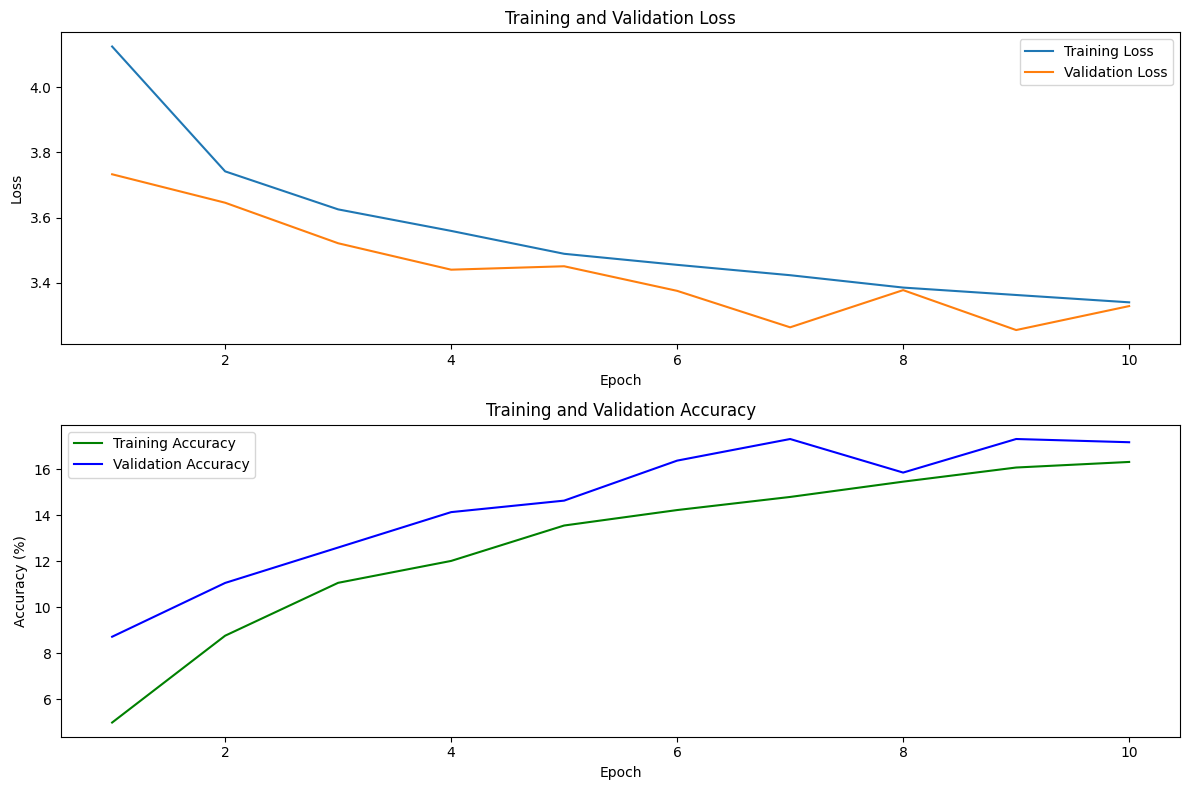

In [4]:
########################################################################
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='g')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()